In [4]:
# Import necessary libraries

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
import warnings
warnings.filterwarnings('ignore')

In [5]:
# Take a glance at the provided data 

raw_data = pd.read_excel('data/dataset.xlsx', engine="openpyxl")

raw_data.info()
raw_data.describe()
raw_data.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5644 entries, 0 to 5643
Columns: 111 entries, Patient ID to ctO2 (arterial blood gas analysis)
dtypes: float64(70), int64(4), object(37)
memory usage: 4.8+ MB


,Patient ID,Patient age quantile,SARS-Cov-2 exam result,"Patient addmited to regular ward (1=yes, 0=no)","Patient addmited to semi-intensive unit (1=yes, 0=no)","Patient addmited to intensive care unit (1=yes, 0=no)",Hematocrit,Hemoglobin,Platelets,Mean platelet volume,...,Hb saturation (arterial blood gases),pCO2 (arterial blood gas analysis),Base excess (arterial blood gas analysis),pH (arterial blood gas analysis),Total CO2 (arterial blood gas analysis),HCO3 (arterial blood gas analysis),pO2 (arterial blood gas analysis),Arteiral Fio2,Phosphor,ctO2 (arterial blood gas analysis)
0,44477f75e8169d2,13,negative,0,0,0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,126e9dd13932f68,17,negative,0,0,0,0.236515,-0.02234,-0.517413,0.010677,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,a46b4402a0e5696,8,negative,0,0,0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,f7d619a94f97c45,5,negative,0,0,0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,d9e41465789c2b5,15,negative,0,0,0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


----

> Data Observation

The provided data contains 111 entries totally. The 3rd to 6th columns (```SARS-Cov-2 exam result```, etc) are the labels we want to predict. Other columns are features we can exploit to predict corresponding labels. However, these features look messed up now because many values of them are missing or intractable.

In [6]:
# Data preprocessing

raw_data.columns = [x.lower().strip().replace(' ','_') for x in raw_data.columns]

def show_missing_features(x):
    total = x.isnull().sum()
    percent = (x.isnull().sum()/x.isnull().count()*100)
    tt = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
    types = []
    for col in raw_data.columns:
        dtype = str(x[col].dtype)
        types.append(dtype)
    tt['Types'] = types
    return(np.transpose(tt))

show_missing_features(raw_data)

,patient_id,patient_age_quantile,sars-cov-2_exam_result,"patient_addmited_to_regular_ward_(1=yes,_0=no)","patient_addmited_to_semi-intensive_unit_(1=yes,_0=no)","patient_addmited_to_intensive_care_unit_(1=yes,_0=no)",hematocrit,hemoglobin,platelets,mean_platelet_volume,...,hb_saturation_(arterial_blood_gases),pco2_(arterial_blood_gas_analysis),base_excess_(arterial_blood_gas_analysis),ph_(arterial_blood_gas_analysis),total_co2_(arterial_blood_gas_analysis),hco3_(arterial_blood_gas_analysis),po2_(arterial_blood_gas_analysis),arteiral_fio2,phosphor,cto2_(arterial_blood_gas_analysis)
Total,0,0,0,0,0,0,5041,5041,5042,5045,...,5617,5617,5617,5617,5617,5617,5617,5624,5624,5617
Percent,0.0,0.0,0.0,0.0,0.0,0.0,89.316088,89.316088,89.333806,89.38696,...,99.521616,99.521616,99.521616,99.521616,99.521616,99.521616,99.521616,99.645641,99.645641,99.521616
Types,object,int64,object,int64,int64,int64,float64,float64,float64,float64,...,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64


---

> Fill Missing Cells

From the table above, we can clearly see the data type and missing percentage of each feature. A simple approach is filling missing cells with the mean value of existing non-nan cells, or a constant. As for label-typed features, we use ```LabelEncoder```. See [sklearn.preprocessing](https://scikit-learn.org/stable/modules/preprocessing.html) for more details!

In [8]:
# Fill in missing features

for x in raw_data.columns:
    if raw_data[x].dtype=='float16' or  raw_data[x].dtype=='float32' or  raw_data[x].dtype=='float64':
        # raw_data[x].fillna(raw_data[x].mean())
        raw_data[x].fillna(raw_data[x].mean(skipna=True), inplace=True)

raw_data = raw_data.fillna(-999)

# Convert label-typed features
for y in raw_data.columns:
    if raw_data[y].dtype=='object': 
        lbl = LabelEncoder()
        lbl.fit(list(raw_data[y].values))
        raw_data[y] = lbl.transform(list(raw_data[y].values))

raw_data.head(5)

,patient_id,patient_age_quantile,sars-cov-2_exam_result,"patient_addmited_to_regular_ward_(1=yes,_0=no)","patient_addmited_to_semi-intensive_unit_(1=yes,_0=no)","patient_addmited_to_intensive_care_unit_(1=yes,_0=no)",hematocrit,hemoglobin,platelets,mean_platelet_volume,...,hb_saturation_(arterial_blood_gases),pco2_(arterial_blood_gas_analysis),base_excess_(arterial_blood_gas_analysis),ph_(arterial_blood_gas_analysis),total_co2_(arterial_blood_gas_analysis),hco3_(arterial_blood_gas_analysis),po2_(arterial_blood_gas_analysis),arteiral_fio2,phosphor,cto2_(arterial_blood_gas_analysis)
0,1588,13,0,0,0,0,-2.186214e-09,-1.601319e-08,-3.535004e-10,7.438142e-09,...,-1.379737e-10,8.416397e-09,-1.655685e-09,4.139211e-10,-7.472139e-09,6.070843e-09,-2.469729e-08,4.656613e-09,6.332993e-09,5.243001e-09
1,451,17,0,0,0,0,2.365154e-01,-2.234027e-02,-5.174130e-01,1.067657e-02,...,-1.379737e-10,8.416397e-09,-1.655685e-09,4.139211e-10,-7.472139e-09,6.070843e-09,-2.469729e-08,4.656613e-09,6.332993e-09,5.243001e-09
2,3669,8,0,0,0,0,-2.186214e-09,-1.601319e-08,-3.535004e-10,7.438142e-09,...,-1.379737e-10,8.416397e-09,-1.655685e-09,4.139211e-10,-7.472139e-09,6.070843e-09,-2.469729e-08,4.656613e-09,6.332993e-09,5.243001e-09
3,5457,5,0,0,0,0,-2.186214e-09,-1.601319e-08,-3.535004e-10,7.438142e-09,...,-1.379737e-10,8.416397e-09,-1.655685e-09,4.139211e-10,-7.472139e-09,6.070843e-09,-2.469729e-08,4.656613e-09,6.332993e-09,5.243001e-09
4,4843,15,0,0,0,0,-2.186214e-09,-1.601319e-08,-3.535004e-10,7.438142e-09,...,-1.379737e-10,8.416397e-09,-1.655685e-09,4.139211e-10,-7.472139e-09,6.070843e-09,-2.469729e-08,4.656613e-09,6.332993e-09,5.243001e-09


---

> Feature Engineering

Feature engineering is always the most time-consuming and energy-consuming part of data analysis. And it is not a deterministic step like algorithms and models, but more about engineering experience and trade-offs. 

Here we provide a simple intuition to select useful features: we calculate the correlations between each feature as the covariance matrix, and then remove the features highly correlated with others (which means this column can be easily linear-combined by others). 

In [9]:
# Calculate the covariance matrix

corr_matrix = raw_data.corr().abs()
corr_matrix.head()

upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))
upper.head()

,patient_id,patient_age_quantile,sars-cov-2_exam_result,"patient_addmited_to_regular_ward_(1=yes,_0=no)","patient_addmited_to_semi-intensive_unit_(1=yes,_0=no)","patient_addmited_to_intensive_care_unit_(1=yes,_0=no)",hematocrit,hemoglobin,platelets,mean_platelet_volume,...,hb_saturation_(arterial_blood_gases),pco2_(arterial_blood_gas_analysis),base_excess_(arterial_blood_gas_analysis),ph_(arterial_blood_gas_analysis),total_co2_(arterial_blood_gas_analysis),hco3_(arterial_blood_gas_analysis),po2_(arterial_blood_gas_analysis),arteiral_fio2,phosphor,cto2_(arterial_blood_gas_analysis)
patient_id,NaN,0.014136,0.018664,0.003748,0.004803,0.000162,0.020071,0.014706,0.006948,0.008635,...,0.011604,0.011653,0.002840,0.010472,0.005338,0.004317,0.005510,0.021115,5.294190e-03,0.003037
patient_age_quantile,NaN,NaN,0.075244,0.046166,0.015736,0.035772,0.031292,0.019498,0.051183,0.038392,...,0.016286,0.034110,0.041484,0.041507,0.006264,0.012090,0.007157,0.021239,4.135060e-02,0.004455
sars-cov-2_exam_result,NaN,NaN,NaN,0.142437,0.019364,0.027586,0.037396,0.039530,0.106482,0.040622,...,0.015189,0.037511,0.015111,0.036451,0.028879,0.024761,0.036186,0.030815,5.314858e-03,0.030967
"patient_addmited_to_regular_ward_(1=yes,_0=no)",NaN,NaN,NaN,NaN,0.011264,0.010192,0.071569,0.075363,0.150186,0.010687,...,0.051133,0.058510,0.008632,0.052540,0.041230,0.034427,0.027247,0.040326,1.377290e-18,0.070462
"patient_addmited_to_semi-intensive_unit_(1=yes,_0=no)",NaN,NaN,NaN,NaN,NaN,0.008087,0.161800,0.157295,0.006185,0.020840,...,0.199293,0.040333,0.080640,0.063793,0.040144,0.048656,0.120723,0.025106,5.392442e-02,0.017481


In [10]:
threshold = 0.92
to_drop = [column for column in upper.columns if any(upper[column] > threshold)]

print('There are %d columns to remove.' % (len(to_drop)))
dataset_rm = raw_data.drop(columns = to_drop) # dropped data
print('Data shape: ', raw_data.shape)
print('Size of the cleaned data', dataset_rm.shape)

There are 28 columns to remove.
Data shape:  (5644, 111)
Size of the cleaned data (5644, 83)


In [11]:
# Dataset contains selected features

dataset_rm.info(verbose=False)
dataset_rm.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5644 entries, 0 to 5643
Columns: 83 entries, patient_id to cto2_(arterial_blood_gas_analysis)
dtypes: float64(66), int32(13), int64(4)
memory usage: 3.3 MB


,patient_id,patient_age_quantile,sars-cov-2_exam_result,"patient_addmited_to_regular_ward_(1=yes,_0=no)","patient_addmited_to_semi-intensive_unit_(1=yes,_0=no)","patient_addmited_to_intensive_care_unit_(1=yes,_0=no)",hematocrit,platelets,mean_platelet_volume,red_blood_cells,...,d-dimer,albumin,hb_saturation_(arterial_blood_gases),pco2_(arterial_blood_gas_analysis),base_excess_(arterial_blood_gas_analysis),total_co2_(arterial_blood_gas_analysis),po2_(arterial_blood_gas_analysis),arteiral_fio2,phosphor,cto2_(arterial_blood_gas_analysis)
0,1588,13,0,0,0,0,-2.186214e-09,-3.535004e-10,7.438142e-09,8.424447e-09,...,-999.0,-5.731216e-09,-1.379737e-10,8.416397e-09,-1.655685e-09,-7.472139e-09,-2.469729e-08,4.656613e-09,6.332993e-09,5.243001e-09
1,451,17,0,0,0,0,2.365154e-01,-5.174130e-01,1.067657e-02,1.020042e-01,...,-999.0,-5.731216e-09,-1.379737e-10,8.416397e-09,-1.655685e-09,-7.472139e-09,-2.469729e-08,4.656613e-09,6.332993e-09,5.243001e-09
2,3669,8,0,0,0,0,-2.186214e-09,-3.535004e-10,7.438142e-09,8.424447e-09,...,-999.0,-5.731216e-09,-1.379737e-10,8.416397e-09,-1.655685e-09,-7.472139e-09,-2.469729e-08,4.656613e-09,6.332993e-09,5.243001e-09
3,5457,5,0,0,0,0,-2.186214e-09,-3.535004e-10,7.438142e-09,8.424447e-09,...,-999.0,-5.731216e-09,-1.379737e-10,8.416397e-09,-1.655685e-09,-7.472139e-09,-2.469729e-08,4.656613e-09,6.332993e-09,5.243001e-09
4,4843,15,0,0,0,0,-2.186214e-09,-3.535004e-10,7.438142e-09,8.424447e-09,...,-999.0,-5.731216e-09,-1.379737e-10,8.416397e-09,-1.655685e-09,-7.472139e-09,-2.469729e-08,4.656613e-09,6.332993e-09,5.243001e-09


---

> **TODO**

**Try to Select or Create Meanful Features from ```raw_data```.**

For example, try dimensionality reduction methods like [PCA](https://en.wikipedia.org/wiki/Principal_component_analysis) or [NMF](https://en.wikipedia.org/wiki/Non-negative_matrix_factorization#:~:text=Non-negative) or [Tree-Based models](https://scikit-learn.org/stable/modules/classes.html#module-sklearn.tree) to weight feature's importance. These tools can be easily found in [scikit-learn](https://scikit-learn.org/stable/modules/classes.html#module-sklearn.decomposition). But it is more encouraged for you to understand the principle behind them and implement them by yourself.

> Requirements
* Conduct feature engineering by using [scikit-learn](https://scikit-learn.org/stable/modules/classes.html#module-sklearn.decomposition) or your own implementation.
* Compare the final test results obtained by your method in your report. 
* Note that you should first read through and complete other parts of this notebook so that you can start for comparison.

In [151]:
label_col = ['patient_id','sars-cov-2_exam_result', 'patient_addmited_to_regular_ward_(1=yes,_0=no)', 'patient_addmited_to_semi-intensive_unit_(1=yes,_0=no)', 'patient_addmited_to_intensive_care_unit_(1=yes,_0=no)']
cols = [x for x in raw_data.columns if x not in label_col] # These columns are the features we can use to predict

"""
PCA实现-numpy
""" 
# 映射的特征维度
k = 100

# 1.标准化 去除均值
raw_data[cols] = raw_data[cols] - raw_data[cols].mean()

# 2.计算协方差矩阵
cov_matrix = raw_data[cols].cov().abs().to_numpy()

# 3.求协方差矩阵的特征根和特征向量
eigen_vals, eigen_vecs = np.linalg.eig(cov_matrix)

# 4.选取主要成分:特征值前k大的特征向量对应的新空间
eigen_val_inds = np.argsort(np.abs(eigen_vals))[-1-k:-1]
W = eigen_vecs[:, eigen_val_inds]
# W = eigen_vecs
dataset_PCA = np.dot(raw_data[cols].to_numpy(), W)

In [12]:
"""
PCA实现 sklearn
"""

from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler

# 对原始数据PCA
label_col = ['patient_id','sars-cov-2_exam_result', 'patient_addmited_to_regular_ward_(1=yes,_0=no)', 'patient_addmited_to_semi-intensive_unit_(1=yes,_0=no)', 'patient_addmited_to_intensive_care_unit_(1=yes,_0=no)']
rd_cols = [x for x in raw_data.columns if x not in label_col] # These columns are the features we can use to predict

dataset_raw = raw_data[rd_cols]

raw_data_scale = MinMaxScaler().fit_transform(dataset_raw.to_numpy())
raw_data_std = StandardScaler().fit_transform(raw_data_scale)

dataset_pca = pd.DataFrame(PCA().fit_transform(raw_data_std))
dataset_pca = pd.DataFrame(raw_data_std)

# dataset_prepsc.head()

# 对去除相关列后的数据进行PCA
label_col = ['patient_id','sars-cov-2_exam_result', 'patient_addmited_to_regular_ward_(1=yes,_0=no)', 'patient_addmited_to_semi-intensive_unit_(1=yes,_0=no)', 'patient_addmited_to_intensive_care_unit_(1=yes,_0=no)']
ds_cols = [x for x in dataset_rm.columns if x not in label_col] # These columns are the features we can use to predict

dataset_rm = dataset_rm[ds_cols]
dataset_rm_scale = MinMaxScaler().fit_transform(dataset_rm.to_numpy())
dataset_rm_std = StandardScaler().fit_transform(dataset_rm_scale)

dataset_rm_pca = pd.DataFrame(PCA(n_components=60).fit_transform(dataset_rm_std))
# dataset_prepsc = pd.DataFrame(dataset_std)

dataset_rm_pca.head()

,0,1,2,3,4,5,6,7,8,9,...,50,51,52,53,54,55,56,57,58,59
0,-0.257237,0.146488,-0.034294,0.023786,-0.030312,-0.017538,0.054862,0.041972,-0.025122,0.039402,...,0.014161,-0.004215,-0.010016,0.015197,-0.010580,0.003589,0.008890,0.000522,-0.002178,-0.006153
1,0.327901,1.869794,-3.347866,0.772605,-1.388803,-1.462476,1.271801,1.029630,-2.819498,2.393101,...,2.193919,-2.147720,-0.029445,0.181668,-0.916607,-0.781689,-0.046557,0.147776,0.132490,-0.227650
2,-0.271449,0.095707,0.011489,0.018311,-0.031859,0.012230,0.001193,0.076568,-0.020402,0.042467,...,0.009946,0.011045,-0.009545,-0.000202,-0.002865,-0.001252,0.002453,0.004738,0.003446,-0.002547
3,-0.279976,0.065238,0.038958,0.015026,-0.032787,0.030091,-0.031009,0.097326,-0.017570,0.044306,...,0.007417,0.020201,-0.009263,-0.009441,0.001764,-0.004156,-0.001409,0.007268,0.006820,-0.000384
4,-0.171364,0.146342,-0.033713,0.000824,0.069736,-0.073495,0.087756,-0.063447,-0.008501,-0.055613,...,-0.022483,-0.058003,-0.010611,0.034907,-0.017794,-0.009062,-0.012400,-0.008161,0.005778,-0.001792


---

> Create Dataset and Split Train/Test Data

The following part builds up our dataset and split them into Train/Test Splits.

In [13]:
# X = dataset_raw # 原始数据特征列
# X = dataset_rm # 原始数据删除相关列
# X = pd.DataFrame(dataset_rm_std) # 原始数据删除相关列并标准化
X = dataset_rm_pca # 原始数据删除后进行PCA

X.head()

,0,1,2,3,4,5,6,7,8,9,...,50,51,52,53,54,55,56,57,58,59
0,-0.257237,0.146488,-0.034294,0.023786,-0.030312,-0.017538,0.054862,0.041972,-0.025122,0.039402,...,0.014161,-0.004215,-0.010016,0.015197,-0.010580,0.003589,0.008890,0.000522,-0.002178,-0.006153
1,0.327901,1.869794,-3.347866,0.772605,-1.388803,-1.462476,1.271801,1.029630,-2.819498,2.393101,...,2.193919,-2.147720,-0.029445,0.181668,-0.916607,-0.781689,-0.046557,0.147776,0.132490,-0.227650
2,-0.271449,0.095707,0.011489,0.018311,-0.031859,0.012230,0.001193,0.076568,-0.020402,0.042467,...,0.009946,0.011045,-0.009545,-0.000202,-0.002865,-0.001252,0.002453,0.004738,0.003446,-0.002547
3,-0.279976,0.065238,0.038958,0.015026,-0.032787,0.030091,-0.031009,0.097326,-0.017570,0.044306,...,0.007417,0.020201,-0.009263,-0.009441,0.001764,-0.004156,-0.001409,0.007268,0.006820,-0.000384
4,-0.171364,0.146342,-0.033713,0.000824,0.069736,-0.073495,0.087756,-0.063447,-0.008501,-0.055613,...,-0.022483,-0.058003,-0.010611,0.034907,-0.017794,-0.009062,-0.012400,-0.008161,0.005778,-0.001792


In [14]:
y = raw_data['sars-cov-2_exam_result'] # predict ```sars-cov-2_exam_result``` (Negative/Positive)

# random split to Train/Test with the ratio of 2:1
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.33, random_state=101) # fixed random seed
X_train.head()

,0,1,2,3,4,5,6,7,8,9,...,50,51,52,53,54,55,56,57,58,59
5248,-0.986074,-2.205672,0.853396,0.338827,-1.066904,-1.109503,-0.568422,-1.644856,1.742532,-0.569496,...,-0.339123,-0.200219,0.040935,-0.686042,0.372504,-0.246119,0.634047,-0.025513,-0.052859,-0.363309
2253,-0.262921,0.126176,-0.015981,0.021596,-0.030930,-0.005631,0.033394,0.055810,-0.023234,0.040628,...,0.012475,0.001889,-0.009828,0.009037,-0.007494,0.001653,0.006315,0.002209,0.000072,-0.004710
1394,-0.277134,0.075394,0.029802,0.016121,-0.032478,0.024137,-0.020275,0.090407,-0.018514,0.043693,...,0.008260,0.017149,-0.009357,-0.006361,0.000221,-0.003188,-0.000122,0.006424,0.005696,-0.001105
2662,-0.274291,0.085550,0.020645,0.017216,-0.032168,0.018184,-0.009541,0.083487,-0.019458,0.043080,...,0.009103,0.014097,-0.009451,-0.003282,-0.001322,-0.002220,0.001165,0.005581,0.004571,-0.001826
2784,-0.194298,-0.066919,0.233235,-0.098035,0.134837,-0.006755,-0.174595,-0.126211,0.035128,-0.082564,...,-0.090804,0.048290,-0.037695,-0.035671,0.033074,-0.021315,-0.030951,0.009059,0.022283,-0.001331


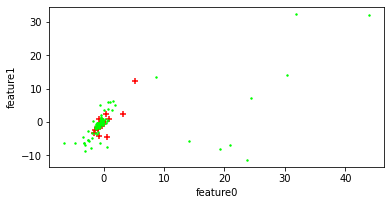

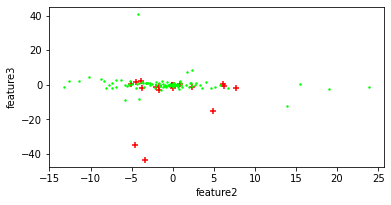

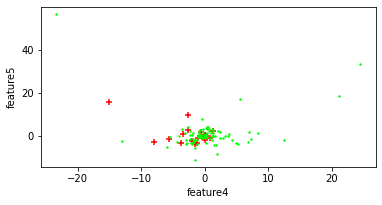

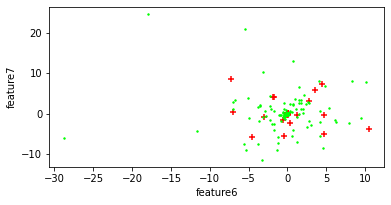

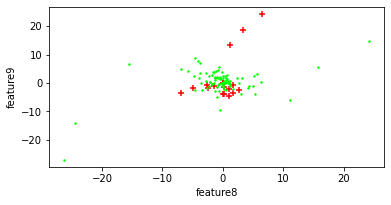

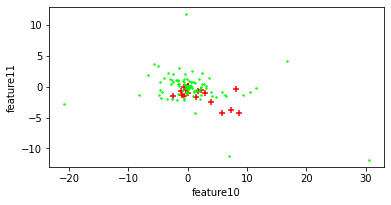

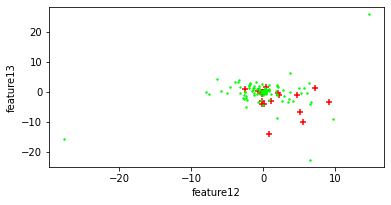

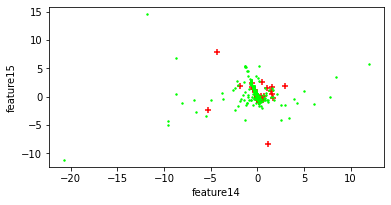

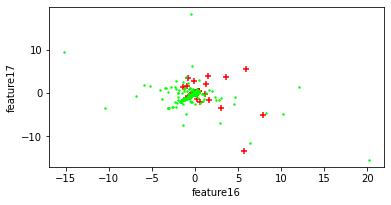

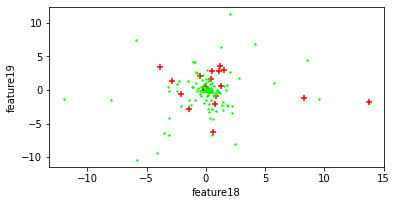

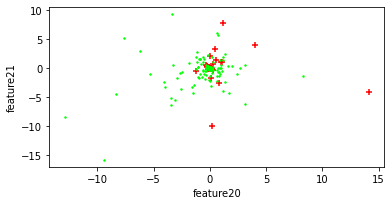

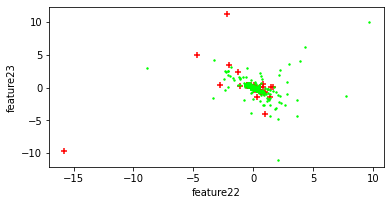

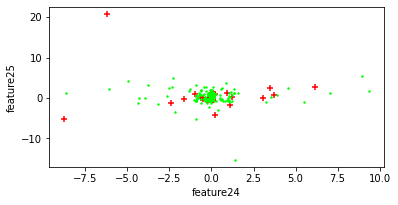

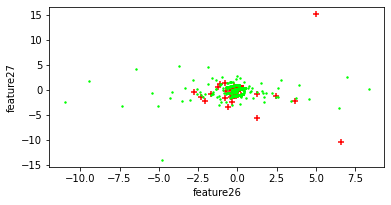

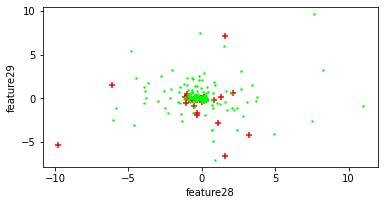

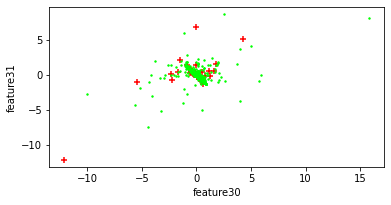

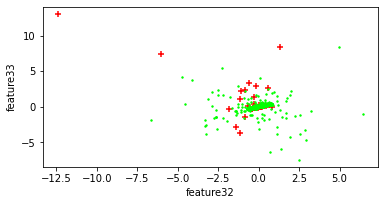

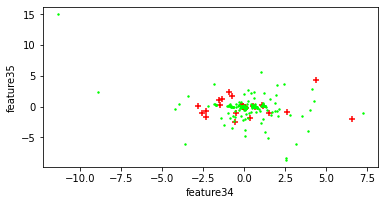

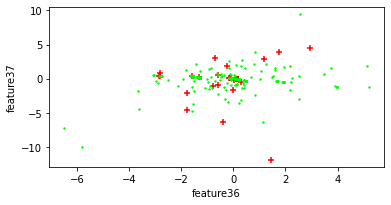

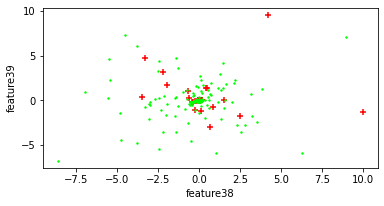

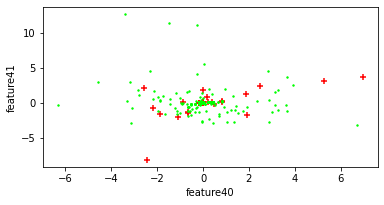

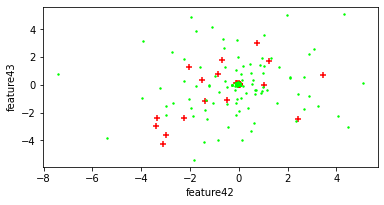

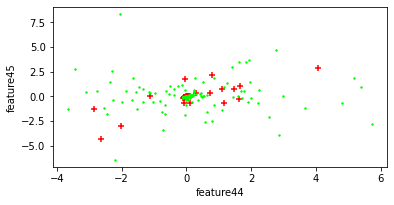

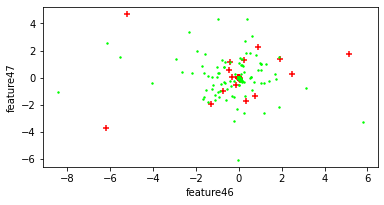

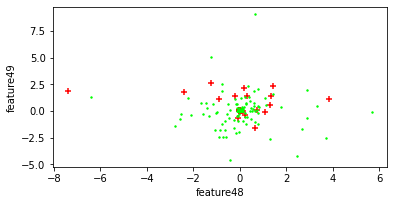

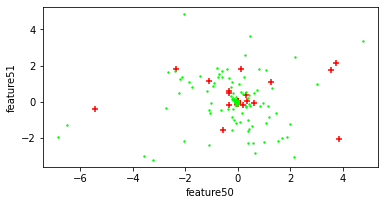

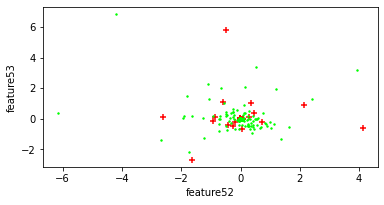

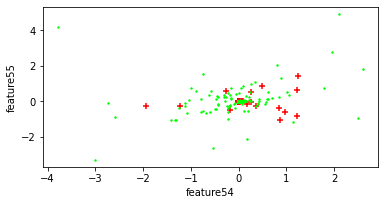

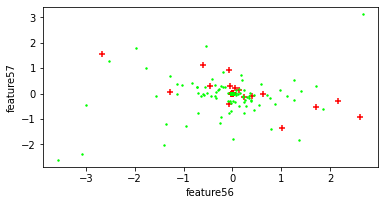

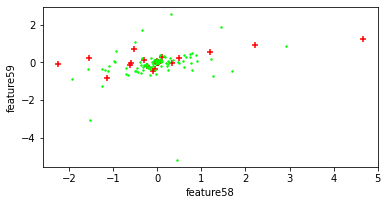

In [15]:
# view train data
def plot_scatter(X,y,v_num, is_numpy=False):
    v_num = 1000
    if is_numpy == False:
        X = X.to_numpy()
        y = y.to_numpy()
    pos_slice = y[0:v_num]==1
    neg_slice = y[0:v_num]==0
    for i in np.arange(0, X.shape[1], 2):
        pos_x = X[0:v_num][pos_slice][:, i: i + 2]
        neg_x = X[0:v_num][neg_slice][:, i: i + 2]
        plt.figure(figsize=(6,10))
        plt.subplot(311)
        plt.scatter(pos_x[:,0],pos_x[:,1],marker='+', c='red')
        plt.scatter(neg_x[:,0],neg_x[:,1],marker='o', s = 2, c='lime')
        plt.xlabel(f'feature{i}')
        plt.ylabel(f'feature{i+1}')
        plt.savefig(f'figures/scatter/feature{i}and{i+1}.png')
        plt.show()

plot_scatter(X_train, y_train, 100, False)

---

> **TODO**

**Select and Train Your Model on ```X_train``` and ```y_train```**

We provide an example of ```LogisticRegression``` and ```DecisionTreeClassifier```. Now it's time for your to select the model you like to conduct classification.

> Requirements
* Select at least **three** other Machine Learning models and train them on the Train split. And you should implement at least **one** by yourself.

In [ ]:
# 过采样
from imblearn.over_sampling import RandomOverSampler

ros = RandomOverSampler(random_state=0)
X_resampled, y_resampled = ros.fit_resample(X_train, y_train)

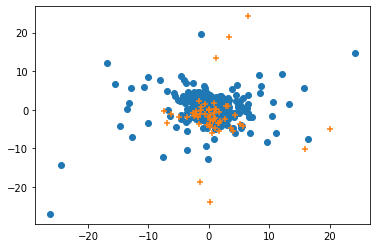

In [15]:
# 欠采样
from imblearn.under_sampling import ClusterCentroids

cc = ClusterCentroids(random_state=0)
X_resampled, y_resampled = cc.fit_resample(X_train, y_train)

v_num = 1000
pos_slice = y_resampled[0:v_num]==1
neg_slice = y_resampled[0:v_num]==0

pos_x = X_resampled.to_numpy()[0:v_num][pos_slice][:, 8:10]
neg_x = X_resampled.to_numpy()[0:v_num][neg_slice][:, 8:10]

# print(pos_x[:,0])

plt.scatter(neg_x[:,0],neg_x[:,1],marker='o')
plt.scatter(pos_x[:,0],pos_x[:,1],marker='+')

plt.show()

In [16]:
# evaluate the model

from sklearn.metrics import confusion_matrix, f1_score, recall_score, precision_score, roc_curve, auc, make_scorer

def my_scoring(y_true, y_pred):
    # 正确率在0.5范围上寻找最高recall-score
    acc = sum(y_pred == y_true)/len(y_pred)
    ans = 0
    if acc > 0.5:
        ans = recall_score(y_true, y_pred)
    return ans

def cross_recall_score(model, X, y):
    sc = cross_val_score(model, X, y, scoring=make_scorer(my_scoring, greater_is_better=True))
    sc = sc.mean()
    print(sc)
    return sc

def tune_param(est, params):
    max_sc = 0
    best_param = {}
    for param in params:
        model = est(**param)
        sc = cross_recall_score(model, X_train, y_train)
        if sc  > max_sc:
            max_sc = sc
            best_param = param
    return best_param, max_sc

def evaluate_model(model, name, print_or_not:bool = True, need_fit = False):
    performance = {}
    
    # cv_acc = 0
    if name == 'K Nearest Neighbors' or name == 'Random Forest' or 'Decision Tree' or need_fit:
        model.fit(X_train, y_train)
        # print(cv_acc)
        # cv_acc = cv_acc.mean()
        # performance['cv_accuracy'] = cv_acc
    prds = model.predict(X_test)
    
    accuracy = accuracy_score(y_test, prds)
    performance['accuracy'] = accuracy
    
    conf_mat = confusion_matrix(y_test, prds)
    performance['confusion_matrix'] = conf_mat
    
    
    precision_sc = precision_score(y_test, prds)
    performance['precision_score'] = precision_sc
    
    
    recall_sc = recall_score(y_test, prds)
    performance['recall_score'] = recall_sc
    
    f1_sc = f1_score(y_test, prds)
    performance['f1_score'] = f1_sc
    
    if print_or_not == True:
        print(f'evaluation of {name}:')
        # print(f'Cross Validation\'s Accuracy of {name}: {cv_acc}')
        
        print(f'Accuracy of {name}: {accuracy}')
        print(f'Confussion Matrix of {name}:\n{conf_mat}')
        print(f"Precision score of {name}: {precision_sc}")
        print(f"Recall score of {name}: {recall_sc}")
        print(f"F1 score of {name}: {f1_sc}")
    
        if name != "Support Vector Machine":
            y_score = model.predict_proba(X_test)[:, 1]
            fpr, tpr, threshold = roc_curve(y_test, y_score)
            roc_auc = auc(fpr, tpr)
            plt.figure(figsize=(6,6))
            plt.title('Validation ROC')
            plt.plot(fpr, tpr, 'b', label = 'Val AUC = %0.3f' % roc_auc)
            plt.legend(loc = 'lower right')
            plt.plot([0, 1], [0, 1],'r--')
            plt.xlim([0, 1])
            plt.ylim([0, 1])
            plt.ylabel('True Positive Rate')
            plt.xlabel('False Positive Rate')
            plt.show()
            
    return performance


In [17]:
# 调整参数

params = []
for i in np.arange(8,13,0.5):
    params.append({'class_weight': {1:i, 0:1}})
param_sel, score = tune_param(LogisticRegression, params)
print(f'selected param:{param_sel} best score:{score}')
# evaluate_model(tree, "Decision Tree")

0.36387559808612446
0.42918660287081334
0.533697881066302
0.31425153793574845
0.2236842105263158
0.0
0.0
0.0
0.0
0.0
selected param:{'class_weight': {1: 9.0, 0: 1}} best score:0.533697881066302


In [21]:
accuracy_lst =[]

def model_assess(model, name='Default'):
    model.fit(X_train, y_train)
    prds = model.predict(X_test)
    model_acc = accuracy_score(y_test, prds)
    accuracy_lst.append(100*model_acc)
    print('Accuracy:', (accuracy_score(y_test, prds)), '\n')
    
def model_assess_get_acc(model, name='Default'):
    model.fit(X_train, y_train)
    prds = model.predict(X_test)
    # model_acc = accuracy_score(y_test, prds)
    print('Accuracy:', (accuracy_score(y_test, prds)), '\n')
    return accuracy_score

evaluation of all_nagetive:
Accuracy of all_nagetive: 0.90552871712292
Confussion Matrix of all_nagetive:
[[1687    0]
 [ 176    0]]
Precision score of all_nagetive: 0.0
Recall score of all_nagetive: 0.0
F1 score of all_nagetive: 0.0


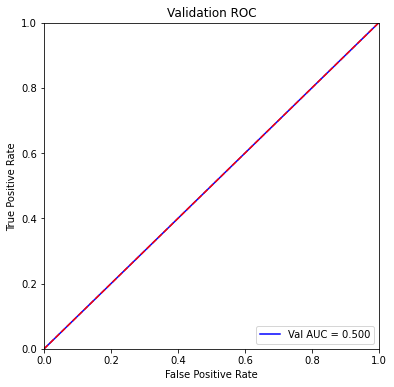

{'accuracy': 0.90552871712292,
 'confusion_matrix': array([[1687,    0],
        [ 176,    0]], dtype=int64),
 'precision_score': 0.0,
 'recall_score': 0.0,
 'f1_score': 0.0}

In [18]:
# naive model - all negative
from sklearn.base import BaseEstimator

class negative_model(BaseEstimator):
    def __init__(self):
        pass
    
    def fit(self, x_train, y_train):
        pass
    
    def predict(self, x_test):
        return np.zeros(shape = x_test.shape[0], dtype='int32')
    
    def predict_proba(self, x_test):
        return np.full((x_test.shape[0],2), fill_value=[1,0])
    
neg_model = negative_model()
evaluate_model(neg_model, 'all_nagetive')

evaluation of Logistic Regression:
Accuracy of Logistic Regression: 0.5797101449275363
Confussion Matrix of Logistic Regression:
[[970 717]
 [ 66 110]]
Precision score of Logistic Regression: 0.13301088270858524
Recall score of Logistic Regression: 0.625
F1 score of Logistic Regression: 0.2193419740777667


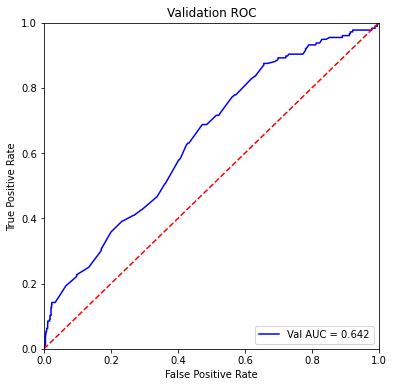

{'accuracy': 0.5797101449275363,
 'confusion_matrix': array([[970, 717],
        [ 66, 110]], dtype=int64),
 'precision_score': 0.13301088270858524,
 'recall_score': 0.625,
 'f1_score': 0.2193419740777667}

In [19]:
# Logistic Regression
lg = LogisticRegression(class_weight={1:9, 0:1})
evaluate_model(lg, 'Logistic Regression')

evaluation of Decision Tree:
Accuracy of Decision Tree: 0.512614063338701
Confussion Matrix of Decision Tree:
[[850 837]
 [ 71 105]]
Precision score of Decision Tree: 0.11146496815286625
Recall score of Decision Tree: 0.5965909090909091
F1 score of Decision Tree: 0.18783542039355994


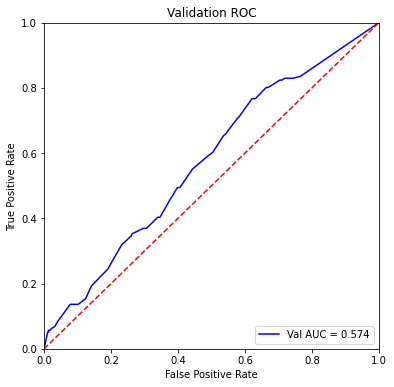

In [20]:
tree = DecisionTreeClassifier(class_weight={1:9, 0:1})
pf = evaluate_model(tree, 'Decision Tree')

In [22]:
# kernel SVM
from sklearn.svm import SVC

SVM_model = SVC(kernel='rbf')
evaluate_model(SVM_model, 'Support Vector Machine')

evaluation of Support Vector Machine:
Accuracy of Support Vector Machine: 0.90552871712292
Confussion Matrix of Support Vector Machine:
[[1686    1]
 [ 175    1]]
Precision score of Support Vector Machine: 0.5
Recall score of Support Vector Machine: 0.005681818181818182
F1 score of Support Vector Machine: 0.011235955056179775


{'accuracy': 0.90552871712292,
 'confusion_matrix': array([[1686,    1],
        [ 175,    1]], dtype=int64),
 'precision_score': 0.5,
 'recall_score': 0.005681818181818182,
 'f1_score': 0.011235955056179775}

In [ ]:
# RF
from sklearn.ensemble import RandomForestClassifier

params = []
for i in np.arange(8,13,0.5):
    params.append({'class_weight': {1:i, 0:1}})
param_sel, score = tune_param(RandomForestClassifier, params)
print(f'selected param:{param_sel} best score:{score}')
# evaluate_model(tree, "Decision Tree")

evaluation of RF:
Accuracy of RF: 0.49221685453569514
Confussion Matrix of RF:
[[812 875]
 [ 71 105]]
Precision score of RF: 0.10714285714285714
Recall score of RF: 0.5965909090909091
F1 score of RF: 0.18166089965397925


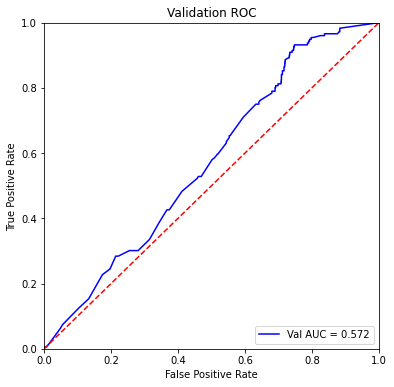

In [25]:
RF_model = RandomForestClassifier(class_weight={1:13, 0:1})
pf = evaluate_model(RF_model, "RF")

evaluation of My Classifier:
Accuracy of My Classifier: 0.703166935050993
Confussion Matrix of My Classifier:
[[1233  454]
 [  99   77]]
Precision score of My Classifier: 0.14500941619585686
Recall score of My Classifier: 0.4375
F1 score of My Classifier: 0.21782178217821782


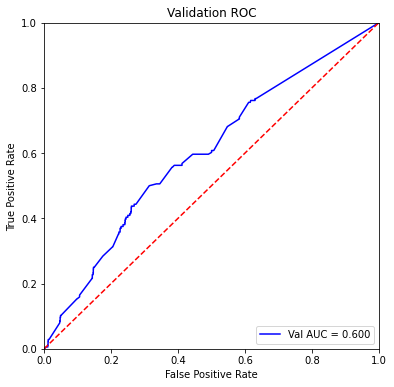

In [26]:
# My classifier
from sklearn.base import BaseEstimator
from scipy.spatial import cKDTree

class MyClassifier(BaseEstimator):
    
    def __init__(self, k=3, class_weight=100):
        self.k = k
        self.class_weight = class_weight

    def fit(self, X_tr, y_tr):
        self.X, idx = np.unique(X_tr.to_numpy(), axis=0, return_index=True) # 去重
        self.y = y_tr.to_numpy()[idx]
        self._data = cKDTree(self.X) # 存入kd-Tree，降低查询速率
        
    def predict(self, X_te):
        y_proba = self.predict_proba(X_te)
        y_pred = []
        for i in range(len(y_proba)):
            if y_proba[i, 1] > 0.5:
                y_pred.append(1)
            else:
                y_pred.append(0)
        return np.array(y_pred)

    def _square_distance(self, v1, v2):
        return np.sum(np.square(v1-v2))
        
    def predict_proba(self, X_te):
        y_proba = []
        for i in range(len(X_te)):
            # print(X_te.to_numpy()[i])
            dists, idx = self._data.query(x=X_te.to_numpy()[i], k=self.k)
            # print(dists)
            max_k_y = self.y[idx] # 前k大的样本
            denom = 0
            nume = 0
            for j in range(self.k):
                dist = dists[j]
                denom = denom + (max_k_y[j] * self.class_weight + (max_k_y[j] == 0) ) / (dist + 0.001) # 更新分母
                nume = nume + (max_k_y[j] * self.class_weight) / (dist + 0.001) # 更新分子
                # print(f'{j}: {dist} {max_k_y[j]} {denom} {nume}')
                
            proba = nume / denom
            y_proba.append([1-proba, proba])
        return np.array(y_proba)
        

# clf = MyClassifier(10, 10)
# clf.fit(X_train, y_train)
# y_score = clf.predict_proba(X_test)
# y_score
evaluate_model(MyClassifier(10, 12), name='My Classifier', need_fit=True)
clf = MyClassifier(10, 12)

evaluation of Naive_Bayes:
Accuracy of Naive_Bayes: 0.8411164787976382
Confussion Matrix of Naive_Bayes:
[[1539  148]
 [ 148   28]]
Precision score of Naive_Bayes: 0.1590909090909091
Recall score of Naive_Bayes: 0.1590909090909091
F1 score of Naive_Bayes: 0.1590909090909091


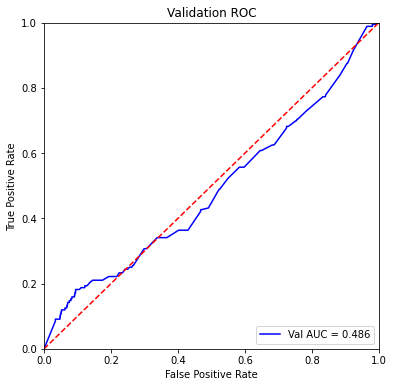

{'accuracy': 0.8411164787976382,
 'confusion_matrix': array([[1539,  148],
        [ 148,   28]], dtype=int64),
 'precision_score': 0.1590909090909091,
 'recall_score': 0.1590909090909091,
 'f1_score': 0.1590909090909091}

In [27]:
# GuassianDB
from sklearn.naive_bayes import GaussianNB
NB_model =GaussianNB()
evaluate_model(NB_model, 'Naive_Bayes', need_fit=True )

In [ ]:
# Demostrate model results on Train split

model_list = ['Logistic Regression', 'DT']

plt.rcParams['figure.figsize']=4,4
sns.set_style('darkgrid')
ax = sns.barplot(x=model_list, y = accuracy_lst, palette = "coolwarm", saturation =2.0)
plt.xlabel('Classifier Models', fontsize = 12)
plt.ylabel('% of Accuracy', fontsize = 12)
plt.title('Accuracy(PCA, n=106)', fontsize = 16)
plt.xticks(fontsize = 12, horizontalalignment = 'center')
plt.yticks(fontsize = 12)
for i in ax.patches:
    width, height = i.get_width(), i.get_height()
    x, y = i.get_xy() 
    ax.annotate(f'{round(height,2)}%', (x + width/2, y + height), ha='center', fontsize = 'x-large')
plt.savefig("figures/LR_DT_Accuracy_PCA_n_106")
plt.show()


In [160]:
# Cross-validaiton

cross_acc = []

ca_lg = cross_val_score(lg, X_train, y_train, scoring='accuracy')
ca_lg = ca_lg.mean()
cross_acc.append(100*ca_lg)

ca_tree = cross_val_score(tree, X_train, y_train, scoring='accuracy')
ca_tree = ca_tree.mean()
cross_acc.append(100*ca_tree)

In [ ]:
# Demostrate model results on Test split

plt.rcParams['figure.figsize']=4,4
sns.set_style('darkgrid')
ax = sns.barplot(x=model_list, y=cross_acc, palette = "rocket", saturation =2.0)
plt.xlabel('Classifier Models', fontsize = 12 )
plt.ylabel('Cross validation Accuracy', fontsize = 12)
plt.title('Accuracy of different Classifier Models', fontsize = 16)
plt.xticks(fontsize = 12, horizontalalignment = 'center')
plt.yticks(fontsize = 12)
for i in ax.patches:
    width, height = i.get_width(), i.get_height()
    x, y = i.get_xy() 
    ax.annotate(f'{round(height,2)}%', (x + width/2, y + height), ha='center', fontsize = 'x-large')
    
plt.savefig("figures/LR_DT_Accuracy_version_0_cross_valid")
plt.show()

---

> **TODO**

**Tune Model for Good Performance on Test Split**

The final objective for training is to obtain a model that performs well on the unseen Test split (not to overfit the Train split). Now it is your time to provide the final solution.

> Requirements
* Try more evaluation methods (like Confusion Matrix, AUC curve and etc.) to make your results more convincing.
* Tune model's hyperparameters by cross-validation and evaluate all your selected models. And give a detailed report on the performance and computational efficiency.
* It is appreciated if other machine learning techniques that help to improve performance are employed.

In [217]:
# cross validation
def cross_valid(model):
    ca = cross_val_score(model, X_train, y_train, scoring='accuracy')
    ca = ca.mean()
    return cross_acc

evaluation of All Negative:
Accuracy of All Negative: 0.90552871712292
Confussion Matrix of All Negative:
[[1687    0]
 [ 176    0]]
Precision score of All Negative: 0.0
Recall score of All Negative: 0.0
F1 score of All Negative: 0.0


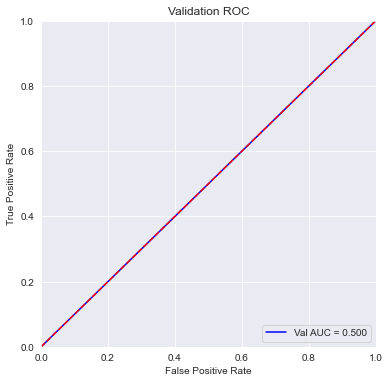

evaluation of Logistic Regression:
Accuracy of Logistic Regression: 0.5797101449275363
Confussion Matrix of Logistic Regression:
[[970 717]
 [ 66 110]]
Precision score of Logistic Regression: 0.13301088270858524
Recall score of Logistic Regression: 0.625
F1 score of Logistic Regression: 0.2193419740777667


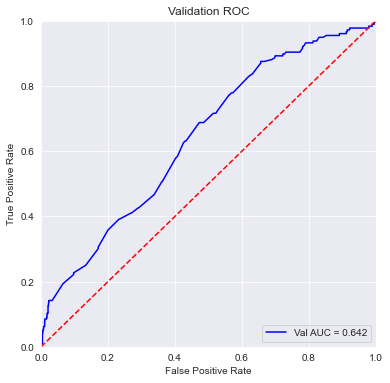

evaluation of Decision Tree:
Accuracy of Decision Tree: 0.5131508319914116
Confussion Matrix of Decision Tree:
[[851 836]
 [ 71 105]]
Precision score of Decision Tree: 0.11158342189160468
Recall score of Decision Tree: 0.5965909090909091
F1 score of Decision Tree: 0.1880035810205909


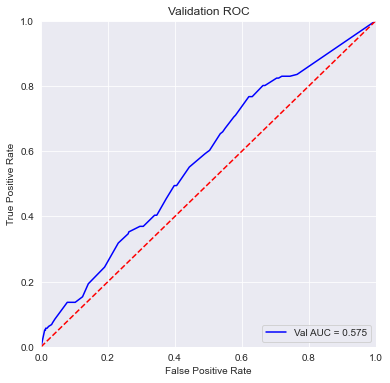

evaluation of Random Forest:
Accuracy of Random Forest: 0.4949006977992485
Confussion Matrix of Random Forest:
[[818 869]
 [ 72 104]]
Precision score of Random Forest: 0.10688591983556012
Recall score of Random Forest: 0.5909090909090909
F1 score of Random Forest: 0.18102697998259354


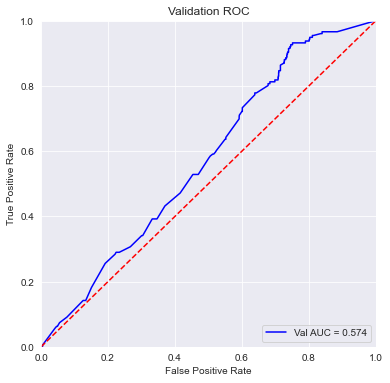

evaluation of Support Vector Machine:
Accuracy of Support Vector Machine: 0.90552871712292
Confussion Matrix of Support Vector Machine:
[[1686    1]
 [ 175    1]]
Precision score of Support Vector Machine: 0.5
Recall score of Support Vector Machine: 0.005681818181818182
F1 score of Support Vector Machine: 0.011235955056179775
evaluation of Improved K Nearest Neighbors:
Accuracy of Improved K Nearest Neighbors: 0.703166935050993
Confussion Matrix of Improved K Nearest Neighbors:
[[1233  454]
 [  99   77]]
Precision score of Improved K Nearest Neighbors: 0.14500941619585686
Recall score of Improved K Nearest Neighbors: 0.4375
F1 score of Improved K Nearest Neighbors: 0.21782178217821782


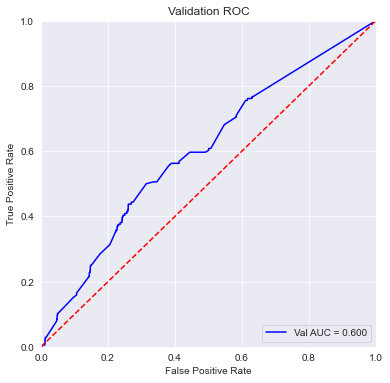

In [29]:
models = [neg_model, lg, tree, RF_model, SVM_model , clf]
model_names = ["All Negative", "Logistic Regression", "Decision Tree", "Random Forest", "Support Vector Machine", "Improved K Nearest Neighbors"]

for i in range(len(models)):
    evaluate_model(models[i], model_names[i])

---

> **TODO**

**Try to Predict for Another Task**

Now, your are familiar with the simple pipeline of data mining. The final task for you is to explore the ```data/dataset.xlsx``` to predict one of the labels above:
* ```patient_addmited_to_regular_ward_(1=yes,_0=no)```
* ```patient_addmited_to_semi-intensive_unit_(1=yes,_0=no)```
* ```patient_addmited_to_intensive_care_unit_(1=yes,_0=no)```

> Requirements
* Use **Row 5001-5645** of ```data/dataset.xlsx``` as the Test Split. Write code or a jupyter notebook to show how you solve this task. Please give detailed comments of your code and a good demonstration of your results.


该部分代码在`predict_task.md`中

---